<a href="https://colab.research.google.com/github/sujitpal/nlp-deeplearning-ai-examples/blob/master/04_04_longformer_multilabel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multi-label Document classification with Longformer

In this notebook, we fine-tune a Longformer transformer to do multi-label classification on the Reuters-21578 dataset.

### Setup

In [1]:
!pip install transformers

In [2]:
!pip install sentencepiece

In [3]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

from nltk.corpus import reuters
from transformers import LongformerTokenizer, LongformerForSequenceClassification
from torch.utils.data import DataLoader, Dataset

%matplotlib inline

### Download and analyze data

This is a subset of the older Reuters-21578 dataset and provides the full text of a subset of documents. A single document can have up to 90 labels. This seems to be about the only place where we can get some text data with multi-labels, [scikit-learn datasets](https://scikit-learn.org/dev/modules/generated/sklearn.datasets.fetch_rcv1.html#sklearn.datasets.fetch_rcv1) and other upstream repositories for the more recent Reuters-RCV1 dataset provide tokenized and TF-IDF vectorized versions.

The article [Classifying Reuters-21578 collection with Python](https://miguelmalvarez.com/2015/03/20/classifying-reuters-21578-collection-with-python-representing-the-data/) by Miguel M Alvarez provided instructions on downloading the dataset from NLTK.

In [4]:
nltk.download("reuters")

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


True

In [5]:
doc_ids = reuters.fileids()
print("Number of documents:", len(doc_ids))

categories = reuters.categories()
print("Number of categories:", len(categories))

Number of documents: 10788
Number of categories: 90


In [6]:
def preprocess_text(text):
  lines_in = text.replace("&lt;", "<").split('\n')
  lines_out = []
  if not lines_in[0].endswith("."):
    lines_out.append(lines_in[0] + ".")
  lines_out.extend([line.strip() for line in lines_in[1:]])
  return " ".join(lines_out)

random_idx = np.random.randint(0, high=len(doc_ids))
print("--- random doc({:d}): {:s} ---".format(random_idx, doc_ids[random_idx]))
print("Document text (orig)\n{:s}".format(reuters.raw(doc_ids[random_idx])))
print("Document text (pre-processed)\n{:s}".format(preprocess_text(reuters.raw(doc_ids[random_idx]))))
print("Categories:", reuters.categories(doc_ids[random_idx]))

--- random doc(821): test/16282 ---
Document text (orig)
SPANISH MONEY SUPPLY GROWING AT DOUBLE TARGET PACE
  Spain's principal measure of money
  supply, the broad-based liquid assets in public hands (ALP),
  grew at an annualised rate of 17.6 pct in March against 16.6
  pct in February and 19.6 pct in March last year, provisional
  Bank of Spain figures show.
      The bank's target range for this year is 6.5 to 9.5 pct,
  and Bank of Spain Governor Mariano Rubio said this month he was
  aiming for the lower end of that range.
      ALP grew by 11.4 pct during 1986.
  


Document text (pre-processed)
SPANISH MONEY SUPPLY GROWING AT DOUBLE TARGET PACE. Spain's principal measure of money supply, the broad-based liquid assets in public hands (ALP), grew at an annualised rate of 17.6 pct in March against 16.6 pct in February and 19.6 pct in March last year, provisional Bank of Spain figures show. The bank's target range for this year is 6.5 to 9.5 pct, and Bank of Spain Governor Mariano 

In [7]:
train_docids = [doc_id for doc_id in doc_ids if doc_id.startswith("training/")]
test_docids = [doc_id for doc_id in doc_ids if doc_id.startswith("test/")]
print("{:d} training and {:d} test examples".format(len(train_docids), len(test_docids)))

7769 training and 3019 test examples


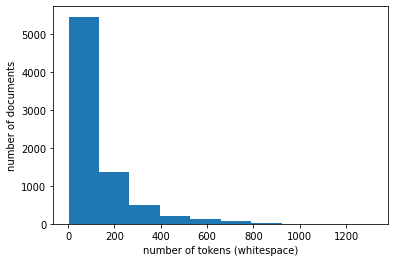

In [8]:
doc_lengths = [len(reuters.raw(doc_id).split()) for doc_id in train_docids]
plt.xlabel("number of tokens (whitespace)")
plt.ylabel("number of documents")
_ = plt.hist(doc_lengths)

In [9]:
idx2cat = {i:c for i, c in enumerate(reuters.categories())}
cat2idx = {v:k for k, v in idx2cat.items()}

len(idx2cat), len(cat2idx)

(90, 90)

### Dataset and DataLoader

In [10]:
class ReutersDataset(Dataset):
  def __init__(self, reuters, docids):
    super().__init__()
    self.reuters = reuters
    self.docids = docids

  def __len__(self):
    return len(self.docids)

  def __getitem__(self, idx):
    doc_id = self.docids[idx]
    text = preprocess_text(self.reuters.raw(doc_id))
    labels = self.reuters.categories(doc_id)
    return text, ",".join(labels)

train_ds = ReutersDataset(reuters, train_docids)
test_ds = ReutersDataset(reuters, test_docids)

In [11]:
# self-test
text, labels = test_ds[12]
print("text:", text)
print("labels:", labels)

text: BOND CORP STILL CONSIDERING ATLAS MINING BAIL-OUT. Bond Corp Holdings Ltd <BONA.S> and Atlas Consolidated Mining and Development Corp <ATLC.MN> are still holding talks on a bail-out package for the troubled mining firm, an Atlas statement said. Atlas, the Philippines' biggest copper producer, said it had been hit by depressed world copper prices. It reported a net loss of 976.38 mln pesos in the year ending December 1986, compared with a net loss of 1.53 billion in 1985. The company said it had been able to cut its losses because its scaled-down copper operations in the central island of Cebu started in the second half of 1986. Atlas said negotiations were continuing on the acquisition by Bond of the company's existing bank loans and their restructuring into a gold loan. A memorandum of understanding signed by the two sides in October last year said Bond would acquire Atlas' total loans of 275 mln dlrs, to be repaid by the mining company in gold. Atlas said the two sides were als

In [12]:
BATCH_SIZE = 4

train_dl = DataLoader(train_ds, shuffle=True, batch_size=BATCH_SIZE)
test_dl = DataLoader(test_ds, shuffle=False, batch_size=BATCH_SIZE)

### Model

In [13]:
tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")
model = LongformerForSequenceClassification.from_pretrained("allenai/longformer-base-4096", num_labels=90)

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', '

In [14]:
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
logits.size()

torch.Size([1, 90])

In [15]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(dev)

### Training

In [16]:
NUM_EPOCHS = 3
LEARNING_RATE = 1e-5
MAX_LENGTH = 768
NUM_CATEGORIES = 90

In [17]:
def convert_labels_to_tensor(labels_batch, num_categories, label2idx):
  label_vecs = []
  for label_str in labels_batch:
    cat_indices = [label2idx[label] for label in label_str.split(",")]
    label_vec = np.zeros((num_categories), dtype=np.float32)
    for i in cat_indices:
      label_vec[i] = 1.0
    label_vecs.append(label_vec)
  return torch.as_tensor(label_vecs)

convert_labels_to_tensor(["acq,copper"], NUM_CATEGORIES, cat2idx)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [18]:
def loss_fn(outputs, targets):
  return torch.nn.BCELoss()(outputs, targets)

optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

In [19]:
def train(train_dl, model, tokenizer, optimizer, loss_fn):
  model.train()
  total_train, total_loss, total_acc = 0, 0, 0
  print("train:", end="")
  for batch_id, batch in enumerate(train_dl):
    if batch_id % 100 == 0:
      print(".", end="")

    text, multilabels = batch
    
    inputs = tokenizer(text, padding=True, truncation=True, 
                       max_length=MAX_LENGTH, return_tensors="pt")
    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask
    input_ids, attention_mask = input_ids.to(dev), attention_mask.to(dev)

    labels = convert_labels_to_tensor(multilabels, NUM_CATEGORIES, cat2idx)
    labels = labels.to(dev)

    outputs = model(input_ids, attention_mask=attention_mask)
    preds = F.softmax(outputs.logits, dim=1)
    loss = loss_fn(preds, labels)

    total_loss += loss.item()
    total_acc += ((preds > 0.5) == labels).sum()
    total_train += labels.size(0)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print()
  return total_loss / total_train, total_acc / (total_train * NUM_CATEGORIES)


def evaluate(val_dl, model, tokenizer, loss_fn):
  model.eval()
  total_val, total_loss, total_acc = 0, 0, 0
  print("validation:", end="")
  for batch_id, batch in enumerate(val_dl):
    if batch_id % 100 == 0:
      print(".", end="")

    text, multilabels = batch

    inputs = tokenizer(text, padding=True, truncation=True,
                       max_length=MAX_LENGTH, return_tensors="pt")
    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask
    input_ids, attention_mask = input_ids.to(dev), attention_mask.to(dev)

    labels = convert_labels_to_tensor(multilabels, NUM_CATEGORIES, cat2idx)
    labels = labels.to(dev)

    with torch.no_grad():
      outputs = model(input_ids, attention_mask=attention_mask)
      preds = F.softmax(outputs.logits, dim=1)
      loss = loss_fn(preds, labels)

    total_loss += loss.item()
    total_acc += ((preds > 0.5) == labels).sum()
    total_val += labels.size(0)

  print()
  return total_loss / total_val, total_acc / (total_val * NUM_CATEGORIES)


In [20]:
train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(train_dl, model, tokenizer, optimizer, loss_fn)
  test_loss, test_acc = evaluate(test_dl, model, tokenizer, loss_fn)
  print("EPOCH {:d}, train loss: {:.3f}, acc: {:.3f}, val_loss: {:.3f}, val_acc: {:.3f}"
    .format(epoch, train_loss, train_acc, test_loss, test_acc))
  
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(test_loss)
  val_accs.append(test_acc)


train:....................
validation:........
EPOCH 1, train loss: 0.007, acc: 0.993, val_loss: 0.004, val_acc: 0.995
train:....................
validation:........
EPOCH 2, train loss: 0.004, acc: 0.995, val_loss: 0.004, val_acc: 0.995
train:....................
validation:........
EPOCH 3, train loss: 0.003, acc: 0.996, val_loss: 0.003, val_acc: 0.995


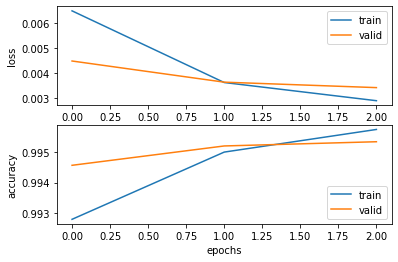

In [21]:
plt.subplot(2, 1, 1)
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="valid")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc="best")

plt.subplot(2, 1, 2)
plt.plot(train_accs, label="train")
plt.plot(val_accs, label="valid")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="best")

_ = plt.show()

### Evaluation

We will create custom implementations of precision, recall, and F1-score for multi-label classification as described in [this CrossValidated page](https://stats.stackexchange.com/questions/12702/what-are-the-measure-for-accuracy-of-multilabel-data).

$$P = \frac{1}{n} \sum_{i=1}^n \frac{|Y_i \cap Z_i|}{|Z_i|} $$
$$R = \frac{1}{n} \sum_{i=1}^n \frac{|Y_i \cap Z_i|}{|Y_i|} $$
$$F_1 = \frac{1}{n} \sum_{i=1}^n \frac{2|Y_i \cap Z_i|}{|Y_i|+|Z_i|} $$

where $Y_i$ is the label vector, and $Z_i$ is the prediction vector respectively for the i-th example. 

In [22]:
def compute_metrics(label, pred):
  mask = label.eq(1)
  label_m = torch.masked_select(label, mask)
  pred_m = torch.masked_select(pred, mask)
  num_overlap = (label_m == pred_m).sum()
  num_labels = label_m.size(-1)
  num_preds = pred_m.size(-1)
  return num_overlap, num_labels, num_preds


total_p, total_r, total_f1, total_batches = 0, 0, 0, 0
for batch in test_dl:

    text, multilabels = batch

    inputs = tokenizer(text, padding=True, truncation=True,
                       max_length=MAX_LENGTH, return_tensors="pt")
    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask
    input_ids, attention_mask = input_ids.to(dev), attention_mask.to(dev)

    labels = convert_labels_to_tensor(multilabels, NUM_CATEGORIES, cat2idx)
    labels = labels.to(dev)

    with torch.no_grad():
      outputs = model(input_ids, attention_mask=attention_mask)
      preds = (F.softmax(outputs.logits, dim=1) > 0.5)

    num_overlap, num_labels, num_preds = compute_metrics(labels, preds)
    p = num_overlap / num_preds
    r = num_overlap / num_labels
    f1 = 2 * num_overlap / (num_preds + num_labels)

    total_p += p
    total_r += r
    total_f1 += f1
    total_batches += 1
    
print("precision: {:.3f}".format(total_p / total_batches))
print("recall:    {:.3f}".format(total_r / total_batches))
print("f1-score:  {:.3f}".format(total_f1 / total_batches))

precision: 0.757
recall:    0.757
f1-score:  0.757
